In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from tqdm import tqdm

from alphagen.utils.dataset import ProteinSmilesDataset
from alphagen.models import AF2SmilesTransformer
from alphagen.utils.utils import VocSmiles, check_smiles
from alphagen.trainer import Runner
import os
from torch.utils.data import DataLoader
import time, random
import numpy as np

from rdkit import Chem

## Suppress RDKit warnings
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# dev = torch.device('cuda')
# devices = [0]

In [4]:
protein_targets_file = '/home/andrius/git/datasets/MonoamineR_human_65.txt'
with open(protein_targets_file, 'r') as prot_list:
    target_proteins = prot_list.readlines()
    target_proteins = [t.strip('\n').strip() for t in target_proteins]

smiles = []
smiles_dict = {}

In [5]:
from alphagen.trainer import load_dataset, load_voc
from alphagen.config import DatasetConfig

## Load the augmented dataset
config = DatasetConfig(dataset_prefix='MonoamineR_human_0_aug_no_Q96RJ0_P21917')
voc = load_voc(config)
augmented = load_dataset(voc, config)

emb_min, emb_max = augmented.emb_min, augmented.emb_max

## Scale novel embeddings appropriately
emb1, _ = augmented.get_protein_embedding('P21917')
emb2, _ = augmented.get_protein_embedding('Q96RJ0')

scaled_embeddings = [(e - emb_min) / (emb_max - emb_min) * 2 - 1 for e in [emb1, emb2]]

## Load the dataset excluding P21917 and Q96RJ0
# config = DatasetConfig(dataset_prefix='MonoamineR_human_0_aug_no_Q96RJ0_P21917')
# voc = load_voc(config)
# augmented = load_dataset(voc, config)

augmented.protein_embeddings['P21917'] = scaled_embeddings[0]
augmented.protein_embeddings['Q96RJ0'] = scaled_embeddings[1]

['_', 'GO', '#', '%', '(', ')', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[CH2]', '[C]', '[I+]', '[IH]', '[N+]', '[N-]', '[O-]', '[OH+]', '[O]', '[P+]', '[S+]', '[SH2]', '[SH]', '[Si]', '[c]', '[n+]', '[n-]', '[nH]', '[s+]', '[se]', '[te]', 'c', 'n', 'o', 's']
P07550 413 384
P08172 466 384
P08173 479 384
P08588 477 384
P08908 422 384
P08912 532 384
P08913 465 384
P11229 460 384
P13945 408 384
P14416 443 384
P18089 450 384
P18825 462 384
P20309 590 384
P21728 446 384
P21917 419 384
P21918 477 384
P25021 359 384
P25100 572 384
P28221 377 384
P28222 390 384
P28223 471 384
P28335 458 384
P28566 365 384
P30939 366 384
P35348 466 384
P35367 487 384
P35368 520 384
P35462 400 384
P41595 481 384
P47898 357 384
P50406 440 384
Q13639 388 384
Q9H3N8 390 384
Q9IP65 354 384
Q9Y5N1 445 384
Dataset: len: 5093659
{'P50406': 167543, 'P28223': 195827, 'P21918': 20647, 'P35367': 72924, 'P08913': 50379, 'P08908

In [6]:
# Load regular dataset
config = DatasetConfig(dataset_prefix='MonoamineR_human_0_aug')
voc = load_voc(config)
unaugmented = load_dataset(voc, config)

['_', 'GO', '#', '%', '(', ')', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[CH2]', '[C]', '[I+]', '[IH]', '[N+]', '[N-]', '[O-]', '[OH+]', '[O]', '[P+]', '[S+]', '[SH2]', '[SH]', '[Si]', '[c]', '[n+]', '[n-]', '[nH]', '[s+]', '[se]', '[te]', 'c', 'n', 'o', 's']
P07550 413 384
P08172 466 384
P08173 479 384
P08588 477 384
P08908 422 384
P08912 532 384
P08913 465 384
P11229 460 384
P13945 408 384
P14416 443 384
P18089 450 384
P18825 462 384
P20309 590 384
P21728 446 384
P21917 419 384
P21918 477 384
P25021 359 384
P25100 572 384
P28221 377 384
P28222 390 384
P28223 471 384
P28335 458 384
P28566 365 384
P30939 366 384
P35348 466 384
P35367 487 384
P35368 520 384
P35462 400 384
P41595 481 384
P47898 357 384
P50406 440 384
Q13639 388 384
Q96RJ0 339 384
Q9H3N8 390 384
Q9IP65 354 384
Q9Y5N1 445 384
Dataset: len: 5559829
{'P50406': 167543, 'P28223': 195827, 'P21918': 20647, 'P35367': 72924, 'P08913':

In [ ]:
from collections import OrderedDict
trainer = Runner(model_num=5793)
embs = OrderedDict(augmented.protein_embeddings)
trainer.dataset.protein_embeddings = embs

target_proteins2 = target_proteins = list(embs.keys())
smiles_dict = {}
for protein in target_proteins:
    p_smiles = trainer.targetted_generation(protein_id=protein, batch_size=10, repeat=50)
    smiles_dict[protein] = p_smiles

['_', 'GO', '#', '%', '(', ')', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[CH2]', '[C]', '[I+]', '[IH]', '[N+]', '[N-]', '[O-]', '[OH+]', '[O]', '[P+]', '[S+]', '[SH2]', '[SH]', '[Si]', '[c]', '[n+]', '[n-]', '[nH]', '[s+]', '[se]', '[te]', 'c', 'n', 'o', 's']
P07550 413 384
P08172 466 384
P08173 479 384
P08588 477 384
P08908 422 384
P08912 532 384
P08913 465 384
P11229 460 384
P13945 408 384
P14416 443 384
P18089 450 384
P18825 462 384
P20309 590 384
P21728 446 384
P21917 419 384
P21918 477 384
P25021 359 384
P25100 572 384
P28221 377 384
P28222 390 384
P28223 471 384
P28335 458 384
P28566 365 384
P30939 366 384
P35348 466 384
P35367 487 384
P35368 520 384
P35462 400 384
P41595 481 384
P47898 357 384
P50406 440 384
Q13639 388 384
Q9H3N8 390 384
Q9IP65 354 384
Q9Y5N1 445 384
Dataset: len: 5093659
{'P50406': 167543, 'P28223': 195827, 'P21918': 20647, 'P35367': 72924, 'P08913': 50379, 'P08908

# Saving SMILES

In [ ]:
## This is for writing the generated smiles

data_dir = '/home/andrius/git/datasets/Monoamines'
for protein in target_proteins:
    subdir = os.path.join(data_dir, protein)
    smiles_dir = os.path.join(subdir, 'model_output')
    os.makedirs(smiles_dir, exist_ok=True)
    smiles_out = os.path.join(smiles_dir, 'smiles3.txt')
    
    ## Write smiles as text
    smiles = smiles_dict[protein]
    with open(smiles_out, 'w') as f:
        f.write("\n".join(smiles))

## Loading smiles

In [7]:
from collections import OrderedDict
embs = OrderedDict(augmented.protein_embeddings)
target_proteins2 = target_proteins = list(embs.keys())
# target_proteins.remove('Q')
# target_proteins2.remove('P28222')
# target_proteins2.remove('Q13639')
# target_proteins2.remove('Q96RJ0')
data_dir = '/home/andrius/git/datasets/Monoamines'
smiles_dict = {}
for protein in target_proteins2:
    protein_dir = os.path.join(data_dir, protein)
    with open(os.path.join(protein_dir, 'model_output', 'smiles3.txt'), 'r') as f:
        smiles_raw = f.readlines()
    
    smiles = [s.strip('\n') for s in smiles_raw]
    smiles_dict[protein] = smiles

# Validity

In [8]:
def validate(smiles):
    
    valid = []
    scores = check_smiles(smiles)
    for i, smile in enumerate(smiles):
        if scores[i] == 1:
            valid.append(smile)
    
    return valid

valid = {}
for protein in target_proteins:
    valid[protein] = validate(smiles_dict[protein])

valid_percentages = [len(valid[p])/len(smiles_dict[p]) for p in target_proteins]
print(valid_percentages)

[0.932, 0.82, 0.928, 0.86, 0.832, 0.928, 0.83, 0.908, 0.856, 0.912, 0.812, 0.808, 0.846, 0.924, 0.866, 0.844, 0.826, 0.866, 0.82, 0.818, 0.786, 0.834, 0.854, 0.834, 0.838, 0.828, 0.84, 0.924, 0.834, 0.904, 0.788, 0.746, 0.886, 0.872, 0.872, 0.838]


In [9]:
## Checking for duplicates (identical SMILES)

non_duplicate = {}
for p in target_proteins:
    smiles_list = valid[p]
    non_dupes = list(set(smiles_list))
    non_duplicate[p] = non_dupes
    print(p, len(smiles_list), len(non_dupes), len(smiles_list) - len(non_dupes))

P07550 466 466 0
P08172 410 410 0
P08173 464 464 0
P08588 430 430 0
P08908 416 416 0
P08912 464 464 0
P08913 415 415 0
P11229 454 454 0
P13945 428 428 0
P14416 456 456 0
P18089 406 405 1
P18825 404 404 0
P20309 423 423 0
P21728 462 462 0
P21917 433 433 0
P21918 422 422 0
P25021 413 413 0
P25100 433 433 0
P28221 410 410 0
P28222 409 409 0
P28223 393 393 0
P28335 417 417 0
P28566 427 427 0
P30939 417 417 0
P35348 419 419 0
P35367 414 414 0
P35368 420 420 0
P35462 462 462 0
P41595 417 417 0
P47898 452 452 0
P50406 394 394 0
Q13639 373 373 0
Q9H3N8 443 443 0
Q9IP65 436 436 0
Q9Y5N1 436 436 0
Q96RJ0 419 419 0


In [10]:
## Canonize to check how many of the generated molecules are unique

non_duplicate_canonized = {}
for p in target_proteins:
    smiles_list = non_duplicate[p]
    canonized = [Chem.CanonSmiles(smile) for smile in smiles_list]
    canonized_non_dupes = list(set(canonized))
    non_duplicate_canonized[p] = canonized_non_dupes
    print(p, len(smiles_list), len(canonized_non_dupes), len(smiles_list) - len(canonized_non_dupes))
    
n_canonized_non_dupes = [len(non_duplicate_canonized[p]) for p in target_proteins]

P07550 466 466 0
P08172 410 409 1
P08173 464 464 0
P08588 430 430 0
P08908 416 416 0
P08912 464 464 0
P08913 415 413 2
P11229 454 454 0
P13945 428 427 1
P14416 456 456 0
P18089 405 404 1
P18825 404 403 1
P20309 423 420 3
P21728 462 462 0
P21917 433 433 0
P21918 422 421 1
P25021 413 411 2
P25100 433 431 2
P28221 410 409 1
P28222 409 408 1
P28223 393 392 1
P28335 417 416 1
P28566 427 427 0
P30939 417 415 2
P35348 419 418 1
P35367 414 413 1
P35368 420 419 1
P35462 462 462 0
P41595 417 417 0
P47898 452 452 0
P50406 394 394 0
Q13639 373 373 0
Q9H3N8 443 440 3
Q9IP65 436 436 0
Q9Y5N1 436 436 0
Q96RJ0 419 419 0


# Loading datasets

In [11]:
means = []
# from collections import OrderedDict
# embs = OrderedDict(augmented.protein_embeddings)
for pid, emb in embs.items():
    print(pid, emb.shape)
    meaned = torch.mean(emb, dim=1)
    means.append(meaned.numpy())

print(means)

P07550 torch.Size([768, 384])
P08172 torch.Size([768, 384])
P08173 torch.Size([768, 384])
P08588 torch.Size([768, 384])
P08908 torch.Size([768, 384])
P08912 torch.Size([768, 384])
P08913 torch.Size([768, 384])
P11229 torch.Size([768, 384])
P13945 torch.Size([768, 384])
P14416 torch.Size([768, 384])
P18089 torch.Size([768, 384])
P18825 torch.Size([768, 384])
P20309 torch.Size([768, 384])
P21728 torch.Size([768, 384])
P21917 torch.Size([768, 384])
P21918 torch.Size([768, 384])
P25021 torch.Size([768, 384])
P25100 torch.Size([768, 384])
P28221 torch.Size([768, 384])
P28222 torch.Size([768, 384])
P28223 torch.Size([768, 384])
P28335 torch.Size([768, 384])
P28566 torch.Size([768, 384])
P30939 torch.Size([768, 384])
P35348 torch.Size([768, 384])
P35367 torch.Size([768, 384])
P35368 torch.Size([768, 384])
P35462 torch.Size([768, 384])
P41595 torch.Size([768, 384])
P47898 torch.Size([768, 384])
P50406 torch.Size([768, 384])
Q13639 torch.Size([768, 384])
Q9H3N8 torch.Size([768, 384])
Q9IP65 tor

# Visualizing AF embeddings for targets (meaned over feature dim)

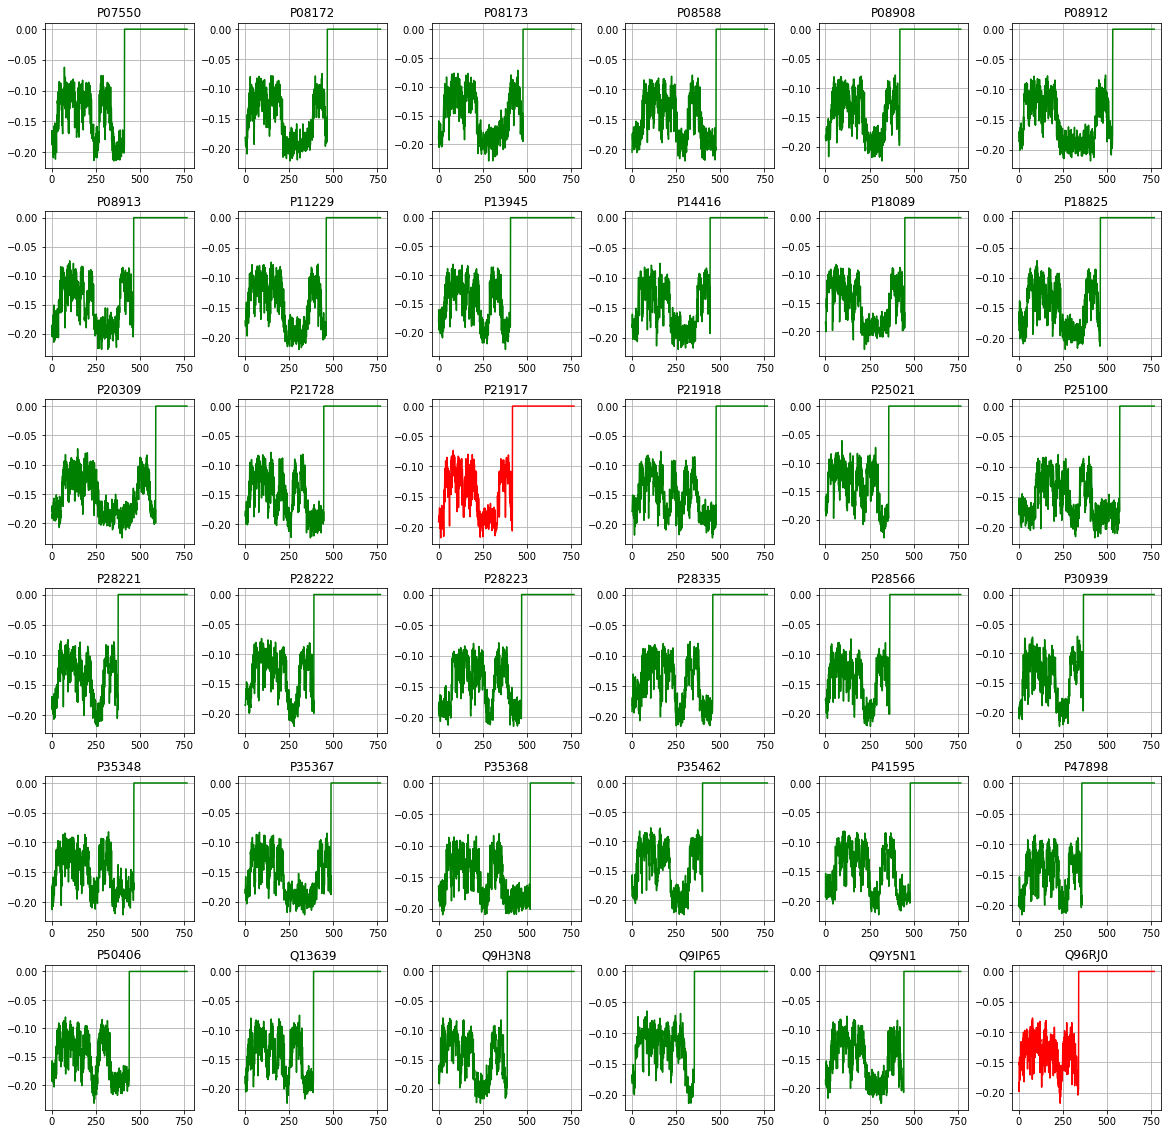

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,20)

for mean in means:
    for i, ind in enumerate(mean):
        if ind < -.24:
            mean[i] = 0
pids = list(embs.keys())
fig = plt.figure()
fig.tight_layout()
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i, pid in enumerate(pids):
    ax = fig.add_subplot(6, 6, i+1)
    c = 'r' if pid in ['P21917', 'Q96RJ0'] else 'g'
    ax.plot(means[i], color=c)
    ax.grid()
    ax.set_title(pid)

In [12]:
## Load names of the proteins
from alphagen.alphafold.papyrus import *

folder = '/media/andrius/Extreme SSD/datasets/foldedPapyrus/proteins'
proteins = [load_protein_sequence(pid, folder) for pid in target_proteins]
headers = [p.info for p in proteins]
names = [h.split('|')[2].split('OS')[0] for h in headers]
print(names)
name_dict = dict(zip(target_proteins, names))
print(name_dict)

['ADRB2_HUMAN Beta-2 adrenergic receptor ', 'ACM2_HUMAN Muscarinic acetylcholine receptor M2 ', 'ACM4_HUMAN Muscarinic acetylcholine receptor M4 ', 'ADRB1_HUMAN Beta-1 adrenergic receptor ', '5HT1A_HUMAN 5-hydroxytryptamine receptor 1A ', 'ACM5_HUMAN Muscarinic acetylcholine receptor M5 ', 'ADA2A_HUMAN Alpha-2A adrenergic receptor ', 'ACM1_HUMAN Muscarinic acetylcholine receptor M1 ', 'ADRB3_HUMAN Beta-3 adrenergic receptor ', 'DRD2_HUMAN D(2) dopamine receptor ', 'ADA2B_HUMAN Alpha-2B adrenergic receptor ', 'ADA2C_HUMAN Alpha-2C adrenergic receptor ', 'ACM3_HUMAN Muscarinic acetylcholine receptor M3 ', 'DRD1_HUMAN D(1A) dopamine receptor ', 'DRD4_HUMAN D(4) dopamine receptor ', 'DRD5_HUMAN D(1B) dopamine receptor ', 'HRH2_HUMAN Histamine H2 receptor ', 'ADA1D_HUMAN Alpha-1D adrenergic receptor ', '5HT1D_HUMAN 5-hydroxytryptamine receptor 1D ', '5HT1B_HUMAN 5-hydroxytryptamine receptor 1B ', '5HT2A_HUMAN 5-hydroxytryptamine receptor 2A ', '5HT2C_HUMAN 5-hydroxytryptamine receptor 2C ',

# Scoring via DrugEx

In [13]:
from drugex.logs import logger
from drugex.training.monitors import FileMonitor

import numpy as np
import pandas as pd
import logging
import os
import copy

from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdDepictor, rdMolDraw2D
opts = Draw.DrawingOptions()
Draw.SetComicMode(opts)

def initLogger(filename, dir_name='data/logs/'):
    """
    Initializes a logging directory if necessary and places all DrugEx outputs in the specified file.
    
    Args:
        filename: name of the log file for DrugEx outputs
        dir_name: directory where the log file will be placed
    """
    
    filename = os.path.join(dir_name, filename)
    
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        
    if os.path.exists(filename):
        os.remove(filename)
    
    formatter = logging.Formatter('%(asctime)s | %(levelname)s | %(message)s', 
                              '%m-%d-%Y %H:%M:%S')
    fh = logging.FileHandler(filename)
    fh.setFormatter(formatter)
    
    logger.addHandler(fh)

# different grid visualizations
standard_grid = Chem.Draw.MolsToGridImage
def interactive_grid(mols, *args, molsPerRow=5, **kwargs):
    """
    install mols2grid with pip to use
    """
    
    import mols2grid
    
    return mols2grid.display(mols, *args, n_cols=molsPerRow, **kwargs)

# show molecules as grid
make_grid = interactive_grid # change this to 'standard_grid' if you do not have the mols2grid package
def smilesToGrid(smiles, *args, molsPerRow=5, **kwargs):
    mols = []
    for smile in smiles:
        try:
            m = Chem.MolFromSmiles(smile)
            if m:
                AllChem.Compute2DCoords(m)
                mols.append(m)
            else:
                raise Exception(f'Molecule empty for SMILES: {smile}')
        except Exception as exp:
            pass
        
    return make_grid(mols, *args, molsPerRow=molsPerRow, **kwargs)

In [14]:
import random

from drugex.training.environment import DrugExEnvironment
from drugex.training.interfaces import Scorer
from drugex.training.scorers.modifiers import ClippedScore
from drugex.training.scorers.predictors import Predictor, Docking
from drugex.training.scorers.properties import Property, Uniqueness
from drugex.training.rewards import ParetoCrowdingDistance
from drugex.utils import canonicalize_list

qed = Property("QED")
sascore = Property("SA")
mw = Property("MW")
# unique = Uniqueness()

# Docking P21917

In [32]:

target_path =  '/home/andrius/git/datasets/Monoamines/P21917/P21917.pdbqt'
active_site = (-2.753, 0.994, -7.633) # Active site coordinates of P21917
output_subfolder = 'drass'

# D4R_docking = Docking(
#     target_pdb_path=target_path,
#     active_site_coords=active_site,
#     output_subfolder=output_subfolder,
#     # modifier=ClippedScore(lower_x=6.5, upper_x=13),
#     visualize=False)

# scorers = [
#     D4R_docking,
#     qed,
#     sascore,
#     mw]
#     # unique]

# thresholds = [
#     6.5,
#     0.6,
#     2,
#     0.0]
# #     # 0.0]


smiles_data1 = protein_smiles_dict['P21917']
smiles_data1 = random.sample(smiles_data1, 500)
smiles_data1 = canonicalize_list(smiles_data1)
smiles_gen1 = non_duplicate_canonized['P21917']

# print(len(smiles_data1), len(smiles_gen1))
# print(smiles_data1[:10])
# environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())
# df_scores_data1 = environment.getScores(smiles_data1)

# output_subfolder = 'drs'

# D4R_docking_ = Docking(
#     target_pdb_path=target_path,
#     active_site_coords=active_site,
#     output_subfolder=output_subfolder,
#     # modifier=ClippedScore(lower_x=6.5, upper_x=13),
#     visualize=False)

# scorers = [
#     D4R_docking_,
#     qed,
#     sascore,
#     mw]
#     # unique]

# thresholds = [
#     6.5,
#     0.6,
#     2,
#     0.0]
# print(len(smiles_gen1))
# environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())
# df_scores_gen1 = environment.getScores(smiles_gen1)

# ########## PLOT ##########

# df_scores

# Q96RJ0

In [19]:

target_path =  '/home/andrius/git/datasets/Monoamines/Q96RJ0/Q96RJ0.pdb'
active_site = (3.1710000038146973, -7.764999866485596, -12.793999671936035)
output_subfolder = 'tas'

TA_docking = Docking(
    target_pdb_path=target_path,
    active_site_coords=active_site,
    output_subfolder=output_subfolder)
    # visualize=True)

scorers = [
    TA_docking,
    qed,
    sascore,
    mw]
    # unique]

thresholds = [
    6.5,
    0.6,
    2,
    0.0]


smiles_data2 = protein_smiles_dict['Q96RJ0']
smiles_data_2 = random.sample(smiles_data2, 500)
smiles_data_2 = canonicalize_list(smiles_data_2)
smiles_gen2 = non_duplicate_canonized['Q96RJ0']
print(smiles_gen2[:10])
print(len(smiles_data_2), len(smiles_gen2))
environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())
df_scores_gen2 = environment.getScores(smiles_gen2)



['CC(CC(=O)NCCc1ccncc1)c1ccc(OCCCN2CCN(C(=O)OC(C)(C)C)CC2)cc1', 'COc1c(C(=O)NCc2nc3cc(N4CCNCC4)ccc3s2)cc(C)n1C', 'O=C(Nc1ccc2c(c1)CCCN2C1CCCC1)c1ccc(Oc2ccc([N+](=O)[O-])cc2)cc1', 'CCCCCCc1cccc(NC(=O)C2CC2)n1', 'COC(=O)c1c(C)c(-c2ccc(OCCCN3CCN(C(=O)c4cc(Cl)c(NC(C)=O)cc4O)CC3)cc2)nn1C(C)C', 'CCOc1cc(N)c(Cl)cc1C(=O)OCCN1CCN(C(=O)c2ccc(-c3ccccc3C#N)cc2)C(C)C1', 'Nc1ncc(COC(=O)N2CCN(C(=O)C3CCc4[nH]c5c(I)cccc5c4C3)CC2)cn1', 'Cn1ccc2cc(C(=O)CN3CCN(C(=O)CSc4ncc[nH]4)CC3)ccc21', 'CC(=O)Oc1ccccc1N1CCN(CC2CCC2NC(=O)c2ccc(Cl)cc2)CC1', 'Cc1ncn2c1N=C2c1ccc(OCCCN2CCN(C(=O)c3ccco3)CC2C)cc1']
369 419
*************************
Docking Q96RJ0.pdb...
*************************
Processing ligands...
Error while preparing ligand: End of sequence hit
[] <class 'list'>
- [2022-10-20 16:54:04 | t=1.25s] Docked ligand 1/784 | Affinity values: [0]...
[] <class 'list'>
- [2022-10-20 16:54:05 | t=1.52s] Docked ligand 2/784 | Affinity values: [0]...
[] <class 'list'>
- [2022-10-20 16:54:06 | t=1.08s] Docked ligand 3

In [18]:
# Q96RJ0 Dataset

output_subfolder = 'tass'

TA_docking_ = Docking(
    target_pdb_path=target_path,
    active_site_coords=active_site,
    output_subfolder=output_subfolder)
    # visualize=True)

scorers = [

    TA_docking_,
    qed,
    sascore,
    mw]
    # unique]

thresholds = [
    6.5,
    0.6,
    2,
    0.0]

environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())
df_scores_data2 = environment.getScores(smiles_data_2)

NameError: name 'smiles_data_2' is not defined

In [ ]:
d = df_scores_data1
dd = smiles_data1
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(d)

## indexes of rows where desire == 1
ids = d[d['DESIRE'] == 1].index
print(ids)
desired1 = [smiles_data1[i] for i in ids]
# df_desired1 = df_scores_data1[df_scores_data1['DESIRE'] == 1]

     Docking(P21917)       QED        SA        MW  DESIRE  VALID
0                7.5  0.770055  2.117770   263.344       1      1
1                6.7  0.706327  2.562148   373.518       1      1
2                8.0  0.463944  2.654945   417.513       0      1
3                7.6  0.739277  2.247557   322.412       1      1
4                7.8  0.720967  2.674367   433.474       1      1
5                8.1  0.813626  2.571355   381.495       1      1
6                7.3  0.400505  2.462330   408.502       0      1
7                7.6  0.581969  2.321351   407.518       0      1
8                4.0  0.400177  3.038627   414.593       0      1
9                8.1  0.674685  2.220446   335.329       1      1
10               6.9  0.813752  2.371844   331.387       1      1
11             -26.9  0.055885  3.381008  1013.287       0      1
12               7.2  0.805006  2.141396   292.386       1      1
13               8.5  0.842013  2.393685   350.466       1      1
14        

IndexError: list index out of range

In [36]:
d = df_scores_data2
dd = smiles_data2
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(d)

## indexes of rows where desire == 1
ids = d[d['DESIRE'] == 1].index
print(ids)
desired2 = [dd[i] for i in ids]
# df_desired1 = df_scores_data1[df_scores_data1['DESIRE'] == 1]

     Docking(Q96RJ0)       QED        SA       MW  DESIRE  VALID
0                5.1  0.790365  1.760492  191.230       0      1
1                5.6  0.814392  3.786149  352.334       0      1
2                5.8  0.881140  1.998922  259.352       0      1
3                6.6  0.680271  2.468872  281.297       1      1
4                7.9  0.658815  1.829134  272.264       0      1
5                7.4  0.893631  1.958357  252.220       0      1
6                7.6  0.256528  2.603566  220.192       0      1
7                4.4  0.360703  2.063256  283.353       0      1
8                4.8  0.408901  2.452616  289.422       0      1
9                6.3  0.544309  3.966843  227.260       0      1
10               6.7  0.776104  1.905909  203.205       0      1
11               6.1  0.548519  2.676682  329.447       0      1
12               5.4  0.647199  2.877518  237.284       0      1
13               6.5  0.872762  1.702276  248.282       0      1
14               0.0  0.8

In [ ]:
smilesToGrid(desired1[::-1])

MolGridWidget()

In [38]:
smilesToGrid(desired2[::-1], molsPerRow=10)

MolGridWidget()

In [ ]:
smilesToGrid(smiles_gen1)

MolGridWidget()

In [39]:
smilesToGrid(smiles_gen2, molsPerRow=10)

MolGridWidget()

# TAAR1_HUMAN Trace amine-associated receptor 1 

In [34]:
smilesToGrid(smiles_data1, molsPerRow=10)

MolGridWidget()

In [ ]:
df_scores_gen1

,Docking(Q96RJ0),QED,SA,MW,DESIRE,VALID
0,8.4,0.505830,1.680408,353.421,0,1
1,7.6,0.868617,2.322038,383.414,1,1
2,3.8,0.330381,2.449043,430.243,0,1
3,0.0,0.690668,2.663339,249.357,0,1
4,4.5,0.694245,2.179593,404.507,0,1
...,...,...,...,...,...,...
428,3.7,0.581980,1.986364,394.475,0,1
429,7.5,0.775734,4.529456,322.324,1,1
430,5.3,0.798262,2.725318,381.520,0,1
431,0.0,0.748269,2.120825,431.334,0,1


In [ ]:
df_scores_data1


,Docking(P21917),QED,SA,MW,DESIRE,VALID
0,7.5,0.770055,2.117770,263.344,1,1
1,6.7,0.706327,2.562148,373.518,1,1
2,8.0,0.463944,2.654945,417.513,0,1
3,7.6,0.739277,2.247557,322.412,1,1
4,7.8,0.720967,2.674367,433.474,1,1
...,...,...,...,...,...,...
327,8.1,0.728451,2.137683,203.329,1,1
328,5.8,0.771252,2.606172,340.398,0,1
329,9.1,0.739739,2.632939,423.557,1,1
330,0.0,0.602991,2.310651,439.556,0,1


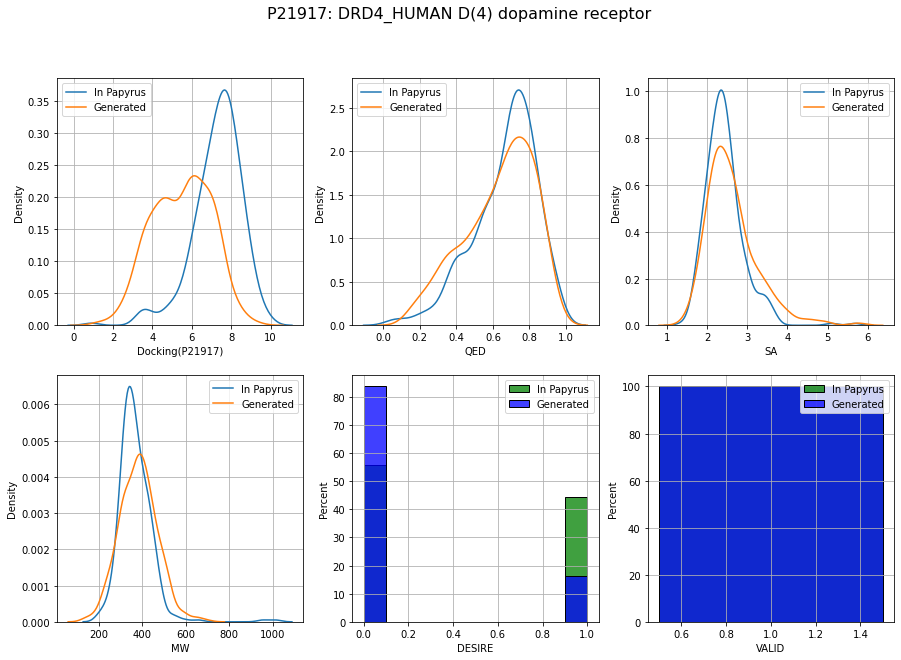

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
dd = df_scores_data1
dg = df_scores_gen1 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('P21917: '+name_dict['P21917'], fontsize=16)
for i, metric in enumerate(df_scores_data1.columns):
    x, y = i // 3, i % 3
    if metric == 'Docking(P21917)':
        sns.kdeplot(ax=axes[x, y], x=dd['Docking(P21917)'][dd['Docking(P21917)'] > 0], label='In Papyrus')
        sns.kdeplot(ax=axes[x, y], x=dg['Docking(Q96RJ0)'][dg['Docking(Q96RJ0)'] > 0], label='Generated')
    if metric == 'DESIRE' or metric == 'VALID':
        sns.histplot(ax=axes[x, y], x=dd[metric], label='In Papyrus', stat='percent', color='g')
        sns.histplot(ax=axes[x, y], x=dg[metric], label='Generated', stat='percent', color='b')
    elif metric in ['QED', 'MW', 'SA']:
        sns.kdeplot(ax=axes[x, y], x=dd[metric], label='In Papyrus')
        sns.kdeplot(ax=axes[x, y], x=dg[metric], label='Generated')
    axes[x, y].grid()
    axes[x, y].legend()
    # axes[x, y].set_title(metric)
    plt.grid()
plt.show()


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_scores_data2)

     Docking(Q96RJ0)       QED        SA       MW  DESIRE  VALID
0                  0  0.725748  2.539796  182.219       0      1
1                  0  0.787005  1.846406  271.297       0      1
2                  0  0.636628  2.767017  261.281       0      1
3                  0  0.662774  3.222953  280.280       0      1
4                  0  0.699249  3.214856  312.464       0      1
5                  0  0.462279  4.253013  235.330       0      1
6                  0  0.748897  2.077029  251.249       0      1
7                  0  0.613736  2.157756  303.433       0      1
8                  0  0.710585  3.176952  305.444       0      1
9                  0  0.798554  2.201645  217.224       0      1
10                 0  0.717953  2.500596  292.349       0      1
11                 0  0.861717  2.000521  296.392       0      1
12                 0  0.840482  2.101984  219.269       0      1
13                 0  0.703159  2.323422  257.322       0      1
14                 0  0.8

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0      0
1      0
2      0
3      1
4      0
      ..
373    0
374    0
375    0
376    0
377    0
Name: DESIRE, Length: 378, dtype: int64
Docking(Q96RJ0)
QED
SA
MW
DESIRE


No handles with labels found to put in legend.


VALID


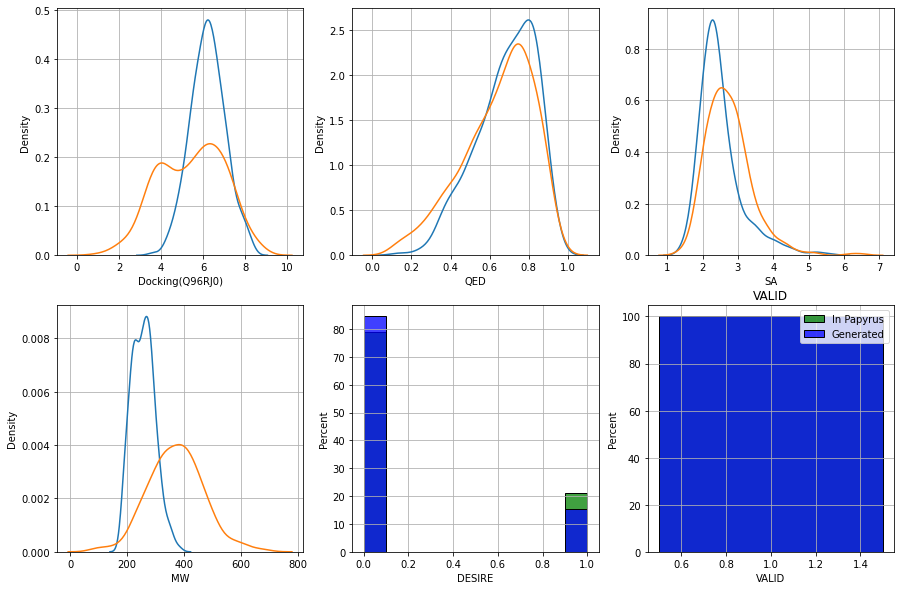

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
dd = df_scores_data2
dg = df_scores_gen2
print(dd.DESIRE)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, metric in enumerate(df_scores_data2.columns):
    x, y = i // 3, i % 3
    plt.grid()
    print(metric)
    if metric == 'Docking(Q96RJ0)' or metric == 'Docking(P21917)':
        sns.kdeplot(ax=axes[x, y], x=dd[metric][dd[metric] > 0], label='In Papyrus')
        sns.kdeplot(ax=axes[x, y], x=dg[metric][dg[metric] > 0], label='Generated')
    elif metric == 'DESIRE' or metric == 'VALID':
        sns.histplot(ax=axes[x, y], x=dd[metric], label='In Papyrus', stat='percent', color='g')
        sns.histplot(ax=axes[x, y], x=dg[metric], label='Generated', stat='percent', color='b')
    else:
        sns.kdeplot(ax=axes[x, y], x=dd[metric], label='In Papyrus')
        sns.kdeplot(ax=axes[x, y], x=dg[metric], label='Generated')
    plt.legend()
    plt.title(metric)
    axes[x,y].grid()
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0      0
1      0
2      0
3      0
4      0
      ..
340    0
341    0
342    0
343    0
344    0
Name: DESIRE, Length: 345, dtype: int64
Docking(P21728)
QED
SA
MW


No handles with labels found to put in legend.
No handles with labels found to put in legend.


DESIRE
VALID


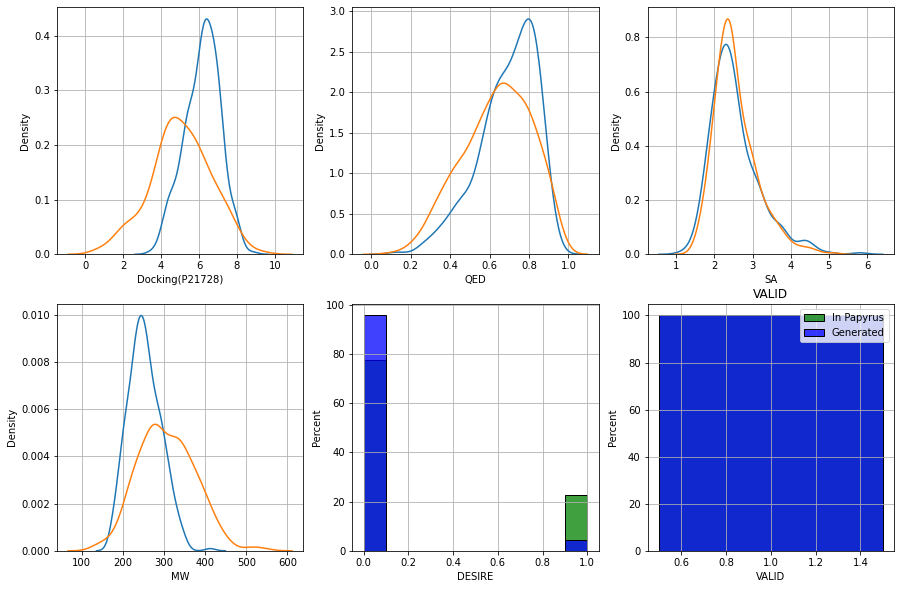

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
dd = df_scores_data3
dg = df_scores_gen3
print(dd.DESIRE)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, metric in enumerate(df_scores_data3.columns):
    x, y = i // 3, i % 3
    plt.grid()
    print(metric)
    if metric == 'Docking(P21728)' or metric == 'Docking(P21917)':
        sns.kdeplot(ax=axes[x, y], x=dd[metric][dd[metric] > 0], label='In Papyrus')
        sns.kdeplot(ax=axes[x, y], x=dg[metric][dg[metric] > 0], label='Generated')
    elif metric == 'DESIRE' or metric == 'VALID':
        sns.histplot(ax=axes[x, y], x=dd[metric], label='In Papyrus', stat='percent', color='g')
        sns.histplot(ax=axes[x, y], x=dg[metric], label='Generated', stat='percent', color='b')
    elif metric == 'MW':
        sns.kdeplot(ax=axes[x, y], x=dd[metric], label='In Papyrus')
        sns.kdeplot(ax=axes[x, y], x=dg[metric]/1.2, label='Generated')
    else:
        sns.kdeplot(ax=axes[x, y], x=dd[metric], label='In Papyrus')
        sns.kdeplot(ax=axes[x, y], x=dg[metric], label='Generated')
    plt.legend()
    plt.title(metric)
    axes[x,y].grid()
plt.show()

# P21728

In [17]:

target_path =  '/home/andrius/git/datasets/Monoamines/P21728/P21728.pdb'

active_site = (-2.68,    4.742, -14.492)# Active site coordinates of P21768
output_subfolder = 'dra2s12'
# del D1R_docking
# D1R_docking = Docking(
#     target_pdb_path=target_path,
#     active_site_coords=active_site,
#     output_subfolder=output_subfolder,
#     # modifier=ClippedScore(lower_x=6.5, upper_x=13),
#     visualize=False)

# scorers = [
#     D1R_docking,
#     qed,
#     sascore,
#     mw]
#     # unique]

# thresholds = [
#     6.5,
#     0.6,
#     2,
#     0.0]
#     # 0.0]


smiles_data3 = protein_smiles_dict['P21728']
smiles_data3 = random.sample(smiles_data3, 500)
smiles_data3 = canonicalize_list(smiles_data3)
smiles_gen3 = non_duplicate_canonized['P21728']

# print(len(smiles_data1), len(smiles_gen1))
# print(smiles_data1[:10])
# environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())
# df_scores_data3 = environment.getScores(smiles_data3)

output_subfolder = 'dra1'

D1R_docking_ = Docking(
    target_pdb_path=target_path,
    active_site_coords=active_site,
    output_subfolder=output_subfolder,
    # modifier=ClippedScore(lower_x=6.5, upper_x=13),
    visualize=False)

scorers = [
    D1R_docking_,
    qed,
    sascore,
    mw]
    # unique]

thresholds = [
    6.5,
    0.6,
    2,
    0.0]
print(len(smiles_gen3))
environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())
df_scores_gen3 = environment.getScores(smiles_gen3)

########## PLOT ##########

# df_scores

462
*************************
Docking P21728.pdb...
*************************
Preparing P21728.pdb for docking: selecting chain [A] and creating /home/andrius/git/DrugEx/drugex/utils/docking/output/dra1/P21728.pdbqt file...
/vina-gpu-dockerized/vina/docking/dra1
Processing ligands...
Error while preparing ligand: End of sequence hit
[-5.2, -4.3, -4.0, -3.9, -3.9, -3.6, -3.5, -3.5, -3.5] <class 'list'>
- [2022-10-20 17:49:38 | t=3.38s] Docked ligand 1/806 | Affinity values: [-5.2, -4.3, -4.0, -3.9, -3.9, -3.6, -3.5, -3.5, -3.5]...
[-4.4, -4.4, -3.4, -1.8] <class 'list'>
- [2022-10-20 17:49:41 | t=3.83s] Docked ligand 2/806 | Affinity values: [-4.4, -4.4, -3.4, -1.8]...
[-4.2, -3.9, -3.7, -3.5, -3.3, -3.2, -2.9, -2.7, -2.6] <class 'list'>
- [2022-10-20 17:49:46 | t=4.7s] Docked ligand 3/806 | Affinity values: [-4.2, -3.9, -3.7, -3.5, -3.3, -3.2, -2.9, -2.7, -2.6]...
[-3.4, -2.9, -2.2] <class 'list'>
- [2022-10-20 17:49:51 | t=4.8s] Docked ligand 4/806 | Affinity values: [-3.4, -2.9, -2.2

In [28]:
print(len(protein_smiles_dict['P21728']))

45289


In [31]:
smilesToGrid(smiles_data1[:500])


NameError: name 'smiles_dat1' is not defined

In [ ]:
smilesToGrid(smiles_gen1)

MolGridWidget()

In [35]:
smilesToGrid(smiles_data_2, molsPerRow=10)

MolGridWidget()

In [ ]:
smilesToGrid(smiles_gen2)

MolGridWidget()

# Loading SMILES from the original dataset

In [15]:
# Isolate smiles based on protein id
## Load the dataset

config = DatasetConfig(dataset_prefix='MonoamineR_human_65')
voc = load_voc(config)

dataset = load_dataset(voc, config)

protein_smiles_dict = {}
all_smiles = []
for line in dataset.tsv_dataset:
    pid, pchembl, smiles = line.split('\t')
    tokens = smiles.split(' ')[:-1]
    joined = ''.join(tokens)

    if protein_smiles_dict.get(pid) is not None:
        protein_smiles_dict[pid] += [joined]
    else:
        protein_smiles_dict[pid] = [joined]
        
    all_smiles += [joined]

all_smiles = list(set(all_smiles))

all_smiles_canonized = []
for smile in all_smiles:
    res = check_smiles([smile])
    if res[0][0] != 0:
        canonized = Chem.CanonSmiles(smile)
        all_smiles_canonized += [canonized]
        
        
print(len(all_smiles), len(all_smiles_canonized))

['_', 'GO', '#', '(', ')', '-', '.', '/', '1', '2', '3', '4', '5', '6', '7', '8', '=', 'B', 'C', 'EOS', 'F', 'I', 'L', 'N', 'O', 'P', 'R', 'S', '[B-]', '[C-]', '[C@@H]', '[C@@]', '[C@H]', '[C@]', '[N+]', '[N-]', '[N@+]', '[O-]', '[OH+]', '[S+]', '[S@+]', '[S@@+]', '[SH]', '[Si]', '[n+]', '[nH]', '[s+]', '[te]', '\\', 'c', 'n', 'o', 's']
P07550 413 384
P08172 466 384
P08173 479 384
P08588 477 384
P08908 422 384
P08912 532 384
P08913 465 384
P11229 460 384
P13945 408 384
P14416 443 384
P18089 450 384
P18825 462 384
P20309 590 384
P21728 446 384
P21917 419 384
P21918 477 384
P25021 359 384
P25100 572 384
P28221 377 384
P28222 390 384
P28223 471 384
P28335 458 384
P28566 365 384
P30939 366 384
P35348 466 384
P35367 487 384
P35368 520 384
P35462 400 384
P41595 481 384
P47898 357 384
P50406 440 384
Q13639 388 384
Q96RJ0 339 384
Q9H3N8 390 384
Q9IP65 354 384
Q9Y5N1 445 384
Dataset: len: 484677
{'Q9H3N8': 730, 'Q9Y5N1': 3276, 'P18089': 294, 'P25021': 88, 'P35367': 842, 'P21728': 45289, 'P20309

# SMILES Ratios

In [ ]:
## Find average length of generated smiles:
mean_l = []
max_l = []
min_l = []

for p in target_proteins:
    lengths = [len(smile) for smile in non_duplicate_canonized[p]]
    mean = np.mean(lengths)
    min_l += [min(lengths)]
    max_l += [max(lengths)]
    mean_l += [mean]
    print(p, mean)

print(target_proteins)
## Find the number of datapoints per protein

data_mean_l = []
# target_proteins.remove('Q9IP65')
# target_proteins += ['Q9IP65']
protein_smiles_dict['Q9IP65'] = []
for p in target_proteins:
    lengths = [len(smile) for smile in protein_smiles_dict[p]]
    mean = np.mean(lengths)
    data_mean_l += [mean]
print(len(target_proteins))
num_datapoints = [len(protein_smiles_dict[p]) for p in target_proteins]

print(target_proteins)
# print(protein_smiles_dict[target_proteins[0]])

P07550 42.74892703862661
P08172 44.117359413202934
P08173 43.94827586206897
P08588 51.04651162790697
P08908 40.54326923076923
P08912 43.161637931034484
P08913 40.23728813559322
P11229 44.22246696035242
P13945 52.67915690866511
P14416 43.61184210526316
P18089 40.631188118811885
P18825 39.71464019851117
P20309 44.364285714285714
P21728 43.77272727272727
P21917 44.96535796766744
P21918 42.049881235154395
P25021 44.13625304136253
P25100 47.874709976798144
P28221 47.16625916870416
P28222 48.65686274509804
P28223 44.52040816326531
P28335 42.87259615384615
P28566 40.950819672131146
P30939 46.23855421686747
P35348 46.538277511961724
P35367 45.27845036319613
P35368 47.89021479713604
P35462 42.64935064935065
P41595 40.77937649880096
P47898 42.89159292035398
P50406 45.84517766497462
Q13639 49.21983914209115
Q9H3N8 37.62954545454546
Q9IP65 41.37844036697248
Q9Y5N1 41.74770642201835
Q96RJ0 43.83293556085919
['P07550', 'P08172', 'P08173', 'P08588', 'P08908', 'P08912', 'P08913', 'P11229', 'P13945', '

In [ ]:
## Check whether generated smiles overlap with the dataset

all_set = set(all_smiles_canonized)
differences = []

for i, protein in enumerate(target_proteins):
    intersect = set(non_duplicate_canonized[protein]).intersection(all_set)
    difference = set(non_duplicate_canonized[protein]).difference(all_set)
    differences += [len(list(difference))]
    print(protein, 
          len(list(intersect)),
          len(list(difference)), round(mean_l[i], 2), min_l[i], max_l[i],
          num_datapoints[i])
# num_datapoints = num_datapoints[:-1]
# num_datapoints.insert(0, 0)

P07550 2 464 42.75 14 73 48276
P08172 5 404 44.12 14 85 1063
P08173 1 463 43.95 15 86 48620
P08588 2 428 51.05 15 94 763
P08908 5 411 40.54 11 70 13872
P08912 3 461 43.16 18 77 48429
P08913 11 402 40.24 11 97 568
P11229 7 447 44.22 15 90 49040
P13945 5 422 52.68 8 95 1355
P14416 3 453 43.61 16 84 46590
P18089 8 396 40.63 14 93 294
P18825 12 391 39.71 11 97 480
P20309 6 414 44.36 14 97 1412
P21728 1 461 43.77 16 82 45289
P21917 2 431 44.97 15 82 1775
P21918 6 415 42.05 15 77 157
P25021 7 404 44.14 14 79 88
P25100 18 413 47.87 18 102 1210
P28221 11 398 47.17 10 98 968
P28222 14 394 48.66 13 90 775
P28223 4 388 44.52 14 87 3048
P28335 11 405 42.87 10 86 1989
P28566 4 423 40.95 1 72 10542
P30939 6 409 46.24 8 95 95
P35348 21 397 46.54 14 98 1685
P35367 8 405 45.28 10 90 842
P35368 21 398 47.89 11 97 1194
P35462 6 456 42.65 19 81 52417
P41595 2 415 40.78 0 76 992
P47898 4 448 42.89 15 72 45848
P50406 9 385 45.85 16 98 2572
Q13639 2 371 49.22 15 91 526
Q9H3N8 9 431 37.63 14 66 730
Q9IP65 1 4

In [ ]:
# names.pop(-1
print(names)


['ADRB2_HUMAN Beta-2 adrenergic receptor ', 'ACM2_HUMAN Muscarinic acetylcholine receptor M2 ', 'ACM4_HUMAN Muscarinic acetylcholine receptor M4 ', 'ADRB1_HUMAN Beta-1 adrenergic receptor ', '5HT1A_HUMAN 5-hydroxytryptamine receptor 1A ', 'ACM5_HUMAN Muscarinic acetylcholine receptor M5 ', 'ADA2A_HUMAN Alpha-2A adrenergic receptor ', 'ACM1_HUMAN Muscarinic acetylcholine receptor M1 ', 'ADRB3_HUMAN Beta-3 adrenergic receptor ', 'DRD2_HUMAN D(2) dopamine receptor ', 'ADA2B_HUMAN Alpha-2B adrenergic receptor ', 'ADA2C_HUMAN Alpha-2C adrenergic receptor ', 'ACM3_HUMAN Muscarinic acetylcholine receptor M3 ', 'DRD1_HUMAN D(1A) dopamine receptor ', 'DRD4_HUMAN D(4) dopamine receptor ', 'DRD5_HUMAN D(1B) dopamine receptor ', 'HRH2_HUMAN Histamine H2 receptor ', 'ADA1D_HUMAN Alpha-1D adrenergic receptor ', '5HT1D_HUMAN 5-hydroxytryptamine receptor 1D ', '5HT1B_HUMAN 5-hydroxytryptamine receptor 1B ', '5HT2A_HUMAN 5-hydroxytryptamine receptor 2A ', '5HT2C_HUMAN 5-hydroxytryptamine receptor 2C ',

36 36 36 36 36
['P07550', 'P08172', 'P08173', 'P08588', 'P08908', 'P08912', 'P08913', 'P11229', 'P13945', 'P14416', 'P18089', 'P18825', 'P20309', 'P21728', 'P21917', 'P21918', 'P25021', 'P25100', 'P28221', 'P28222', 'P28223', 'P28335', 'P28566', 'P30939', 'P35348', 'P35367', 'P35368', 'P35462', 'P41595', 'P47898', 'P50406', 'Q13639', 'Q9H3N8', 'Q9IP65', 'Q9Y5N1', 'Q96RJ0']


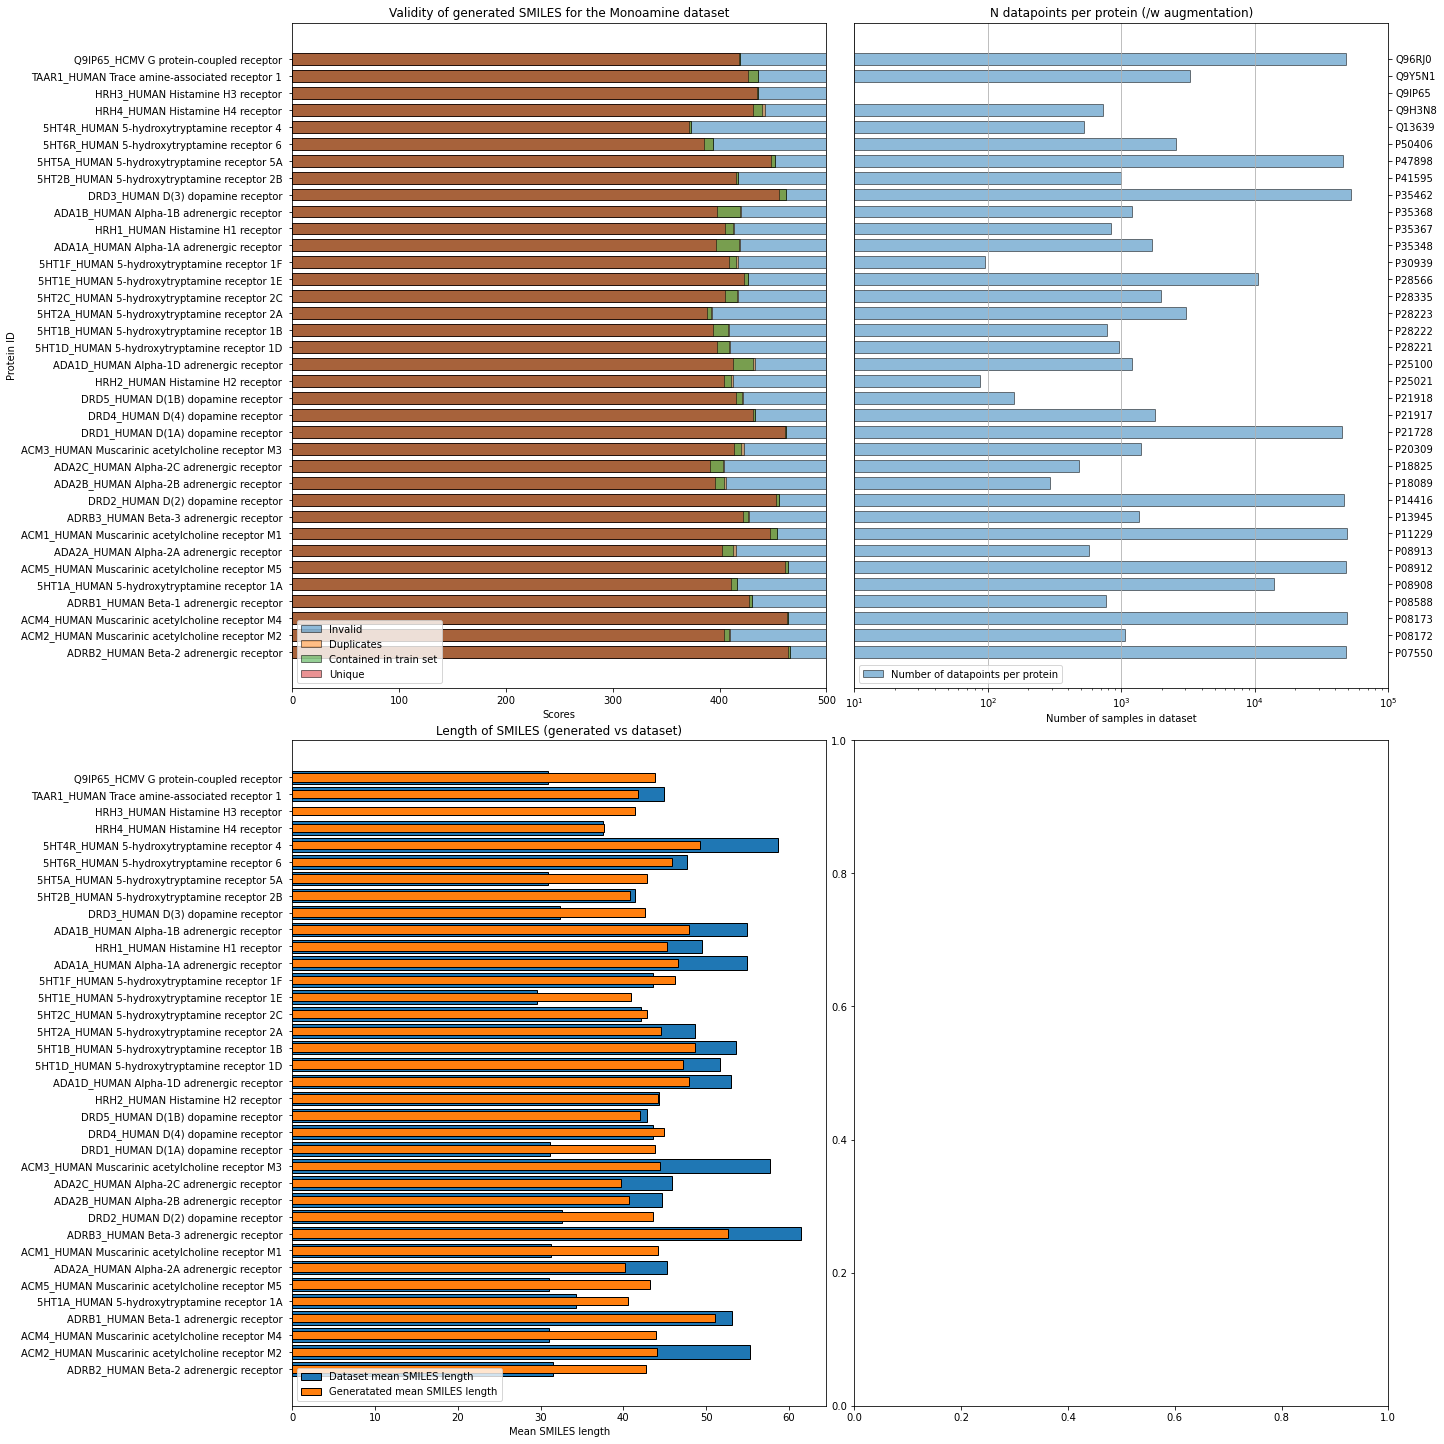

In [ ]:
from unicodedata import name
import matplotlib.pyplot as plt
# set plt figsize
plt.rcParams["figure.figsize"] = (20,20)
fig, [[ax, ax2], [ax3, ax4]] = plt.subplots(2, 2)
labels = target_proteins
width = 0.7
alpha = 0.5

# print(len(list(difference)), len(valid_percentages))
# print(valid_percentages[0], n_canonized_non_dupes[0], differences[0])
valid = [v * 500 for v in valid_percentages]
total = [500 for _ in range(len(valid))]

print(len(total), len(valid), len(n_canonized_non_dupes), len(names), len(differences))## 1 ##
ax.barh(names, total, width, label='Invalid', alpha=alpha, edgecolor='k')
ax.barh(names, valid, width, label='Duplicates', alpha=alpha, edgecolor='k')
ax.barh(names, n_canonized_non_dupes, width, label='Contained in train set', alpha=alpha, edgecolor='k')
ax.barh(names, differences, width, label='Unique', alpha=alpha, edgecolor='k')
ax.set_xlabel('Scores')
ax.set_ylabel('Protein ID')
ax.set_xlim(0, 500)
ax.set_title('Validity of generated SMILES for the Monoamine dataset')
ax.legend(loc='lower left')



## 2 ##
ax2.barh(labels, num_datapoints, width, label='Number of datapoints per protein', alpha=0.5, edgecolor='k')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Number of samples in dataset')
ax2.set_xscale('log')
ax2.set_xlim(10e0, 10e4)
ax2.grid(axis='x')
ax2.set_title('N datapoints per protein (/w augmentation)')
ax2.legend(loc='lower left')

## 3 ##
ax3.barh(names, data_mean_l, 0.8, label='Dataset mean SMILES length', alpha=1, edgecolor='k')
ax3.barh(names, mean_l, width-0.2, label='Generatated mean SMILES length', alpha=1, edgecolor='k')

ax3.set_xlabel('Mean SMILES length')
ax3.set_title('Length of SMILES (generated vs dataset)')
ax3.legend(loc='lower left')


print(labels)
fig.tight_layout(pad=0.5)
plt.show()


# Centroids

In [ ]:
print(len(protein_smiles_dict['Q96RJ0']))
print(len(protein_smiles_dict['P21917']))

47897
1775


In [56]:
## Centroids
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

# target_proteins.remove('Q9IP65')
# target_proteins.remove('Q9Y5N1')

target_proteins = ['P21917', 'Q96RJ0', 'Q9H3N8', 'P21728', 'P28222', 'P20309', 'P30939', 'Q9IP65', 'Q13639', 'P28221', 'P25021', 'P13945', 'P08908', 'P08588', 'P28223', 'P25100', 'P18089', 'P28335', 'P35462', 'P08913', 'P21918', 'P50406', 'P28566', 'P08912', 'P18825', 'Q9Y5N1', 'P47898', 'P41595', 'P35367', 'P07550', 'P08172', 'P14416', 'P11229', 'P08173', 'P35368', 'P35348']
target_proteins.sort()

fp_gen_centroid = {}
fps = []
for protein in target_proteins:
    print(protein)
    smiles_gen = non_duplicate_canonized[protein]
    # smiles_dat = protein_smiles_dict[protein]
    mol_gen = [Chem.MolFromSmiles(smile) for smile in smiles_gen]
    try:

        fp_raw = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mol_gen]
        fps += [fp_raw]
    except:
        pass
    print(len(fp_raw))
    

n = len(target_proteins)  - 1 
print(n)
Centroid_dists = np.zeros([n, n])
for k in range(n):
    for l in range(n):
        d1 = len(fps[k])
        d2 = len(fps[l])
        D = np.zeros([d1, d2])
        for i in range(d1):
            for j in range(d2):
                try:
                    sim = DataStructs.TanimotoSimilarity(fps[k][i], fps[l][j])
                except:
                    sim = 0
                D[i, j] = sim

        mean = np.mean(D)            
        Centroid_dists[k, l] = mean
        print(k, l, mean)

        

P07550
466
P08172
409
P08173
464
P08588
430
P08908
416
P08912
464
P08913
413
P11229
413
P13945
427
P14416
456
P18089
404
P18825
403
P20309
420
P21728
462
P21917
433
P21918
421
P25021
411
P25100
431
P28221
409
P28222
408
P28223
392
P28335
416
P28566
427
P30939
415
P35348
418
P35367
413
P35368
419
P35462
462
P41595
417
P47898
452
P50406
394
Q13639
373
Q96RJ0
419
Q9H3N8
440
Q9IP65
436
Q9Y5N1
436
35
0 0 0.14150229429554873
0 1 0.12312882249386072
0 2 0.13845303423526917
0 3 0.13208332181172958
0 4 0.1391409161970666
0 5 0.13922793139806722
0 6 0.12144569341107325
0 7 0.13294995202425902
0 8 0.1394458282406318
0 9 0.1242245770659649
0 10 0.12252663962809614
0 11 0.12622605153788033
0 12 0.1390749024907664
0 13 0.13797941458953955
0 14 0.12690708285040142
0 15 0.13166307893400012
0 16 0.13084846281758997
0 17 0.12579016468459964
0 18 0.12616078148130447
0 19 0.12863094927217417
0 20 0.12765295514007474
0 21 0.13966630269502645
0 22 0.13255195170086412
0 23 0.13124774728384636
0 24 0.12927991

<AxesSubplot:>

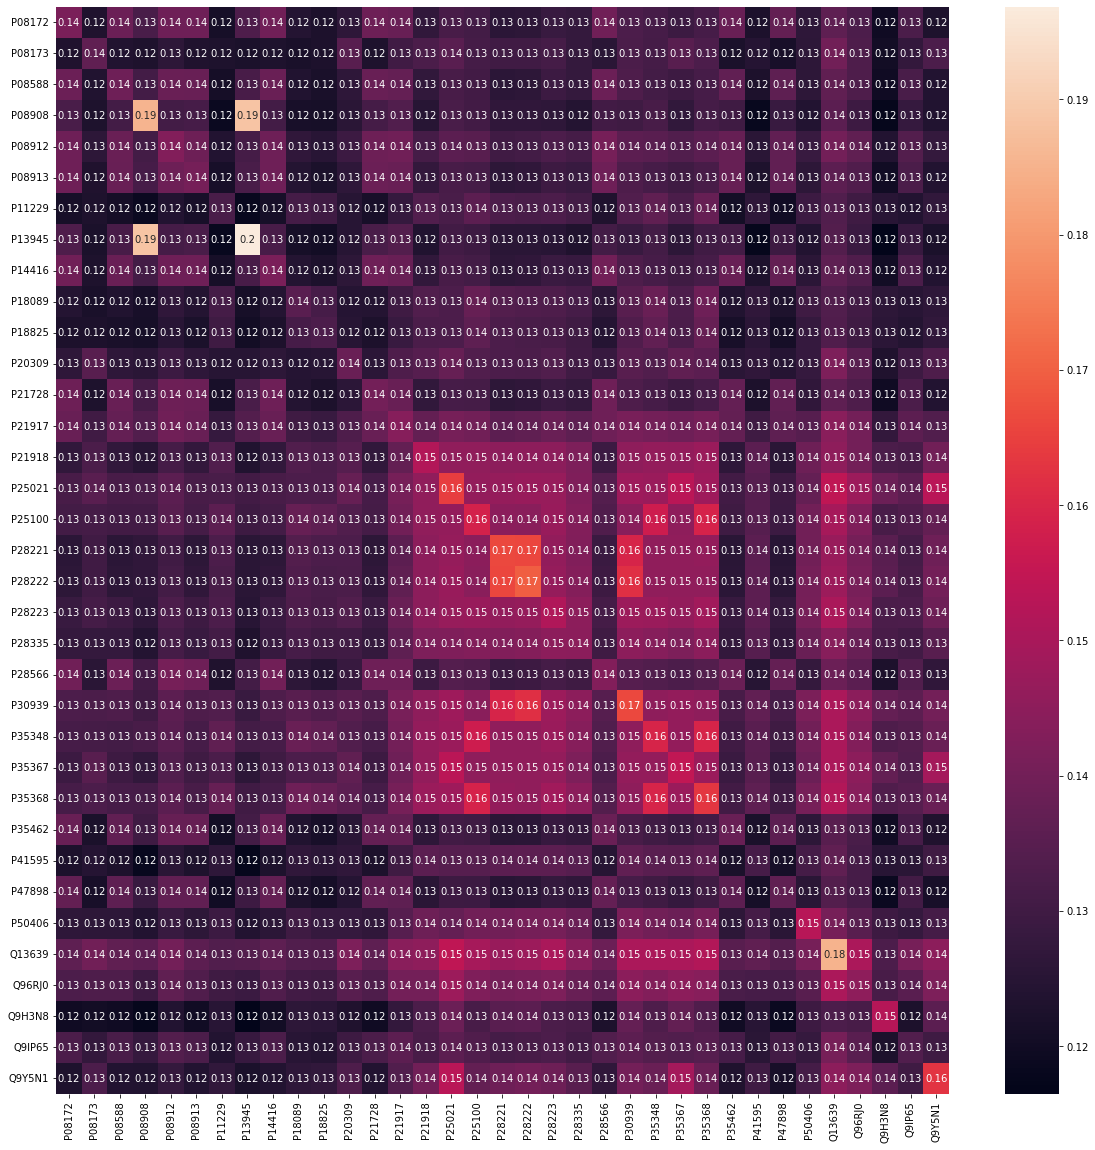

In [57]:
import seaborn as sn
import pandas as pd
import copy

c2 = copy.deepcopy(Centroid_dists)
for i in range(len(c2)):
    c2[i, i] = c2[i, i]# * 1.2

df_cm = pd.DataFrame(c2, target_proteins[1:],
                  columns = target_proteins[1:])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)